In [1]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is 

In [4]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class OLIVESDataset(Dataset):
    """
    A PyTorch Dataset for the OLIVES data.
    Including image, six binary biomarker labels,
    and other features for each sample.
    """
    def __init__(self, hf_dataset, transform=None):
        """
        Args:
            hf_dataset (Dataset):
              dataset['train']/dataset['test']
            transform (optional):
              A function/transform to apply to the images.
        """
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample within this Dataset.

        Returns:
            tuple: (image_tensor, numeric_tensor, label_tensor)
            - image_tensor: The transformed image (CHW format).
            - numeric_tensor: A tensor containing numeric features such as BCVA and CST.
            - label_tensor: A tensor of shape (6,) containing the six biomarker labels.
        """
        sample = self.hf_dataset[idx]

        image = sample["Image"]
        # Apply Transformer
        if self.transform is not None:
            image = self.transform(image)

        # Biomarkers
        labels = torch.zeros(6, dtype=torch.float64)

        biomarker_keys = ["B1", "B2", "B3", "B4", "B5", "B6"]
        for i, key in enumerate(biomarker_keys):
            val = sample.get(key, None)
            labels[i] = val

        # BCVA and CST.
        bcva = sample["BCVA"]
        cst  = sample["CST"]

        extra_features = torch.tensor([bcva, cst], dtype=torch.float64)

        return image, labels, extra_features

    def __len__(self):
        return len(self.hf_dataset)

In [5]:
if __name__ == "__main__":
    from datasets import load_dataset
    from torch.utils.data import DataLoader

    olives = load_dataset("gOLIVES/OLIVES_Dataset", "biomarker_detection")

    columns_to_check = ["B1", "B2", "B3", "B4", "B5", "B6", "BCVA", "CST"]

    def filter_none(example):
    # Return True if all relevant fields are not None
      return all(example[col] is not None for col in columns_to_check)


    # resize and convert to tensor
    # Feel free to add more
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor()
    ])

    train_filter = olives["train"].filter(filter_none)
    test_filter  = olives["test"].filter(filter_none)

    train_dataset = OLIVESDataset(hf_dataset=train_filter, transform=transform)
    test_dataset  = OLIVESDataset(hf_dataset=test_filter, transform=transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=True)



Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

Filter:   0%|          | 0/78822 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3871 [00:00<?, ? examples/s]

In [9]:
# First one is for the train dataset with length 78822
# Second is for test dataset
print(olives)

# All in tensor
print("Loader Structure: Image, 6 biomarkers, bcva & cst")
print(train_dataset[0])

DatasetDict({
    train: Dataset({
        features: ['Image', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'BCVA', 'CST', 'Eye_ID', 'Patient_ID'],
        num_rows: 78822
    })
    test: Dataset({
        features: ['Image', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'BCVA', 'CST', 'Eye_ID', 'Patient_ID'],
        num_rows: 3871
    })
})
Loader Structure: Image, 6 biomarkers, bcva & cst
(tensor([[[0.0118, 0.0078, 0.0157,  ..., 0.0157, 0.0157, 0.0275],
         [0.0078, 0.0118, 0.0157,  ..., 0.0275, 0.0392, 0.0196],
         [0.0784, 0.0745, 0.0235,  ..., 0.0314, 0.0471, 0.0275],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]), tensor([1., 0., 1., 1., 0., 1.], dtype=torch.float64), tensor([ 82., 326.], dtype=torch.float64))


In [7]:
for image, label, extra in train_loader:
        print("Image batch shape:", image.shape)       # Image
        print("Numeric features:", extra.shape)       # BCVA & CST
        print("Labels:", label.shape)             # Lables
        break

Image batch shape: torch.Size([16, 1, 224, 224])
Numeric features: torch.Size([16, 2])
Labels: torch.Size([16, 6])


Image batch shape: torch.Size([16, 1, 224, 224])
Numeric features shape: torch.Size([16, 6])
Labels shape: torch.Size([16, 2])


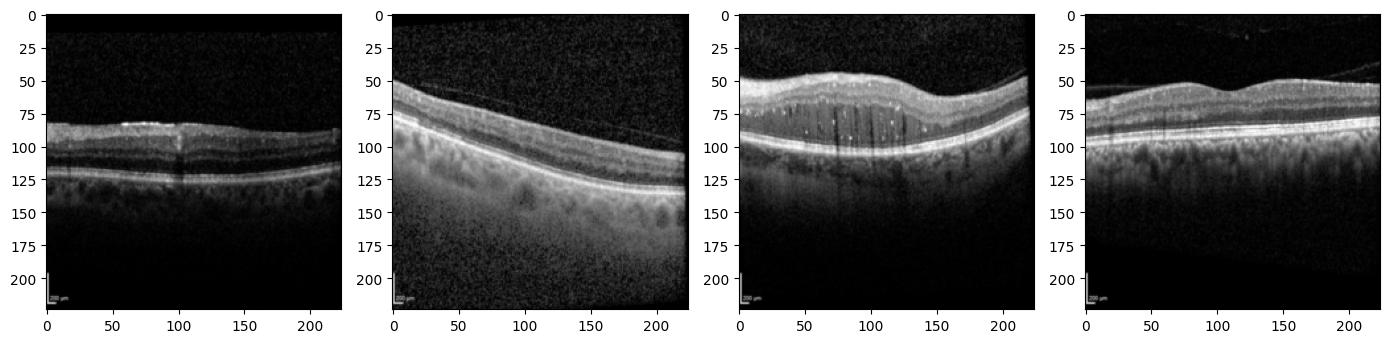

In [10]:
import matplotlib.pyplot as plt

def show_images(images, n=4):
    """
    Display the first n images in a batch.
    """
    # Create a row of subplots.
    fig, axes = plt.subplots(1, n, figsize=(3.5*n, 3.5))

    for i in range(n):
        # [C, H, W] -> [H, W, C] so matplotlib can show correctly.
        img = images[i].permute(1, 2, 0).cpu().numpy()

        axes[i].imshow(img[..., 0], cmap='gray')

    plt.tight_layout()
    plt.show()

# Example
images, extra, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Numeric features shape:", extra.shape)
print("Labels shape:", labels.shape)

# Display the first 4 images in batch
show_images(images, n=4)
